In [ ]:
# import pandas as pd
import numpy as np
import os
base_path = '/Users/freezylex/Documents/course_work/'

# Upload daily data from Bloomberg & RUREPO + CBR

In [2]:
dir_rates = 'data/raw_data/rates_OTC_market'
file_names = sorted(os.listdir(os.path.join(base_path, dir_rates)))

### Read

first = True
for i in range(len(file_names)):
    if file_names[i][-4:] != 'xlsx':
        pass
    else:
        data = pd.read_excel(os.path.join(base_path, 
                                          dir_rates, 
                                          file_names[i])).reset_index(drop=True).set_index('Date')
        if first:
            rates = data
            first = False
        else:
            rates = rates.merge(data, on='Date', how='outer', sort=True)
rates.head(3)

,overnight_mosprime,1W,2W,1M,2M,3M,6M,10_year,overnight,1_year,2_year,3_year,4_year,5_year,6_year,7_year,8_year,9_year
Date,,,,,,,,,,,,,,,,,,
2015-03-02,15.95,15.99,16.06,16.56,16.76,17.07,17.07,13.350,16.0,16.99,15.400,14.65,14.20,13.91,13.7019,13.56,13.46,13.39
2015-03-03,15.96,15.98,16.06,16.55,16.76,17.06,17.09,13.345,16.0,17.04,15.380,14.65,14.18,13.90,13.7000,13.56,13.45,13.38
2015-03-04,15.94,15.98,16.05,16.50,16.73,17.05,17.08,13.245,16.0,NaN,15.295,14.56,14.10,13.79,13.5900,13.46,13.36,13.29


In [3]:
rates.shape #previous had 245 rows

(255, 18)

In [4]:
rates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255 entries, 2015-03-02 to 2016-02-19
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   overnight_mosprime  242 non-null    float64
 1   1W                  242 non-null    float64
 2   2W                  242 non-null    float64
 3   1M                  242 non-null    float64
 4   2M                  242 non-null    float64
 5   3M                  242 non-null    float64
 6   6M                  242 non-null    float64
 7   10_year             236 non-null    float64
 8   overnight           244 non-null    float64
 9   1_year              150 non-null    float64
 10  2_year              242 non-null    float64
 11  3_year              241 non-null    float64
 12  4_year              240 non-null    float64
 13  5_year              254 non-null    float64
 14  6_year              233 non-null    float64
 15  7_year              242 non-null    fl

In [5]:
105/255

0.4117647058823529

In [6]:
pd.DataFrame(rates.isna().sum().sort_values(), columns = ['number_of_missings']).T

,5_year,overnight,7_year,2_year,6M,overnight_mosprime,2M,1M,2W,1W,3M,3_year,4_year,10_year,9_year,8_year,6_year,1_year
number_of_missings,1,11,13,13,13,13,13,13,13,13,13,14,15,19,20,22,22,105


In [7]:
pd.DataFrame(rates.isna().sum().sort_values(), columns = ['number_of_missings']).T.to_excel(os.path.join(
base_path, 'stats/missing_OTC.xlsx'))

In [8]:
pd.DataFrame(rates.isna().sum(
    axis=1).sort_values(ascending=False).head(20), 
             columns = ['number_of_missing_rates']).T

Date,2015-05-11,2015-05-04,2015-03-09,2016-01-08,2016-01-01,2015-12-31,2015-08-31,2015-04-06,2015-07-23,2015-07-22,2015-05-25,2015-07-20,2015-07-24,2015-11-04,2015-07-27,2016-01-07,2016-01-04,2015-06-12,2016-01-06,2015-05-01
number_of_missing_rates,17,17,17,13,10,10,9,9,9,9,9,9,9,9,9,9,8,8,8,8


In [9]:
pd.DataFrame(rates.isna().sum(
    axis=1).sort_values(ascending=False), 
             columns = ['number_of_missing_rates']).value_counts('number_of_missing_rates').to_excel(os.path.join(
base_path, 'stats/missing_OTC_groupby_init.xlsx'))

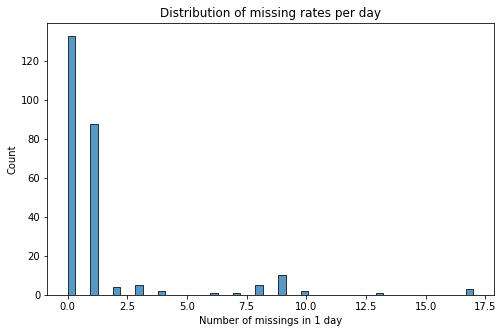

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(rates.isna().sum(axis=1).values)
plt.title('Distribution of missing rates per day')
plt.xlabel('Number of missings in 1 day')
plt.show()

## Filling task

- Days with number of available rates less than 6 will be excluded
- We need to find a way how to fill 1^st year of rates

Solution: take RoisFIX 6M, build a non-linear regression on available data and fit other dates

In [11]:
roisfix = pd.read_excel(os.path.join(base_path, 'data/raw_data/roisfix.xlsx'), index_col='Date',
                       parse_dates = True)
roisfix.head(3)

,1W,2W,1M,2M,3M,6M
Date,,,,,,
2015-03-02,15.52,15.63,15.20,14.88,14.70,14.48
2015-03-03,15.58,15.65,15.18,14.93,14.76,14.56
2015-03-04,15.53,15.59,15.10,14.86,14.76,14.56


In [12]:
roisfix.shape #Data available for 243 days. Less than CBR rates for 2 days

(243, 6)

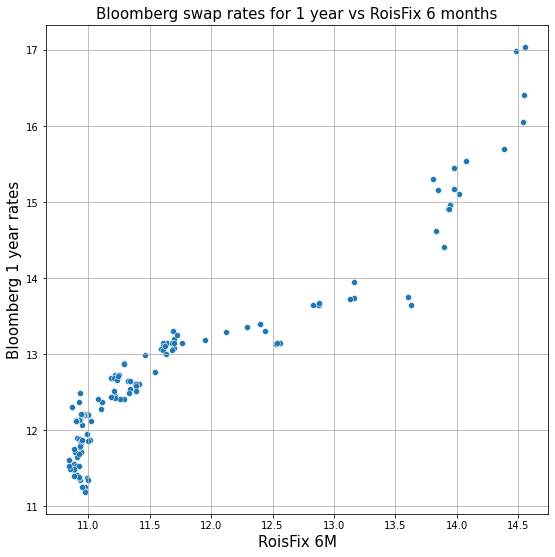

In [13]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.scatterplot(x = roisfix['6M'], y = rates['1_year'])
plt.xlabel('RoisFix 6M', fontsize=15)
plt.ylabel('Bloomberg 1 year rates', fontsize=15)
plt.title('Bloomberg swap rates for 1 year vs RoisFix 6 months', fontsize=15)
plt.grid()
plt.savefig(os.path.join(base_path, 'graphs/bloom_roisfix.png'), dpi=300)

 - Idea: apply cubic regression

In [14]:
data_for_reg = pd.DataFrame(roisfix['6M'].reset_index()).merge( #mos
               pd.DataFrame(rates['1_year'].reset_index()), 
               how='outer', on='Date')

data_for_reg['6M_2'] = data_for_reg['6M'] ** 2
data_for_reg['6M_3'] = data_for_reg['6M'] ** 3
data_for_reg['const'] = 1

data_for_reg.head(2)

,Date,6M,1_year,6M_2,6M_3,const
0,2015-03-02,14.48,16.99,209.6704,3036.027392,1
1,2015-03-03,14.56,17.04,211.9936,3086.626816,1


In [15]:
to_fill = data_for_reg.loc[data_for_reg['1_year'].isna() == True] #sample to be filled later
data_for_reg = data_for_reg.loc[data_for_reg.isna().sum(axis=1) == 0] #sample for regression

In [16]:
data_for_reg.shape

(146, 6)

In [17]:
train = data_for_reg.sample(n = 125, random_state = 27) #85%
test = data_for_reg.loc[~data_for_reg.index.isin(train.index)]

In [18]:
from statsmodels.regression.linear_model import OLS

model = OLS(train['1_year'], train[['6M', '6M_2', '6M_3','const']]).fit()
predictions = model.predict()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 1_year   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     593.2
Date:                Sat, 16 Apr 2022   Prob (F-statistic):           3.71e-72
Time:                        16:48:03   Log-Likelihood:                -20.366
No. Observations:                 125   AIC:                             48.73
Df Residuals:                     121   BIC:                             60.04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
6M           164.4795     14.452     11.381      0.000     135.868     193.091
6M_2         -13.2146      1.168    -11.317      0.000     -15.526     -10.903
6M_3           0.3544      0.031     11.317      0.000       0.292       0.416
const       -669.9736     59.370    -11.285      0.000    -787.513    -552.434
==============================================================================
Omnibus:                        6.377   Durbin-Watson:                   2.414
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                5.881
Skew:                          -0.492   Prob(JB):                       0.0528
Kurtosis:                       3.402   Cond. No.                     3.92e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
from sklearn.metrics import r2_score, mean_squared_error

In [20]:
test_predictions = model.predict(test[['6M', '6M_2', '6M_3','const']])
print(f'R squared: {r2_score(test["1_year"], test_predictions)}')
print(f'MSE: {mean_squared_error(test["1_year"], test_predictions)}')
print(f'RMSE: {mean_squared_error(test["1_year"], test_predictions, squared=False)}')

R squared: 0.9161902075550566
MSE: 0.14752329363048017
RMSE: 0.3840876119200933


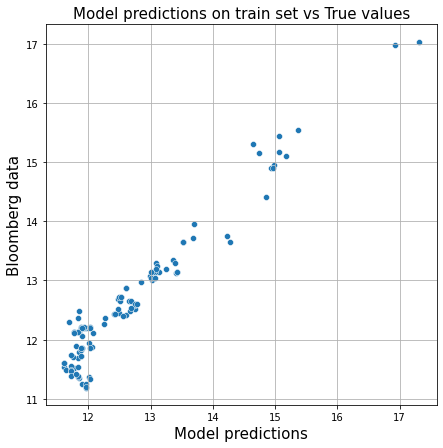

In [21]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(y = train['1_year'], x = predictions)
plt.ylabel('Bloomberg data', fontsize=15)
plt.xlabel('Model predictions', fontsize=15)
plt.title('Model predictions on train set vs True values', fontsize=15)
plt.grid()
plt.show()

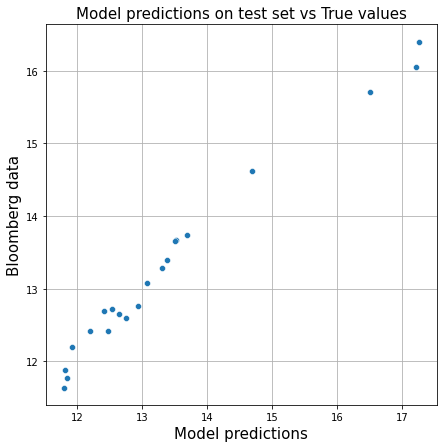

In [22]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(y = test['1_year'], x = test_predictions)
plt.ylabel('Bloomberg data', fontsize=15)
plt.xlabel('Model predictions', fontsize=15)
plt.title('Model predictions on test set vs True values', fontsize=15)
plt.grid()
plt.show()

In [23]:
to_fill = to_fill[to_fill['6M'].notna()] #Delete rows where there is no information about Mosprime rate
preds_to_fill = model.predict(to_fill[['6M', '6M_2', '6M_3','const']])
to_fill['1_year'] = preds_to_fill

In [24]:
new_data_1_year = to_fill[['1_year', 'Date']]
new_data_1_year.head(2)

,1_year,Date
2,17.306515,2015-03-04
6,15.590162,2015-03-11


In [25]:
rates.loc[new_data_1_year['Date'], '1_year'] = new_data_1_year['1_year'].values #Fill in available data

### Check for missing rates per day

In [26]:
mask = (rates.isna().sum(axis=1) >= 9) #Number of maximum allowed NaN values
rates = rates[~mask]
rates = rates[~rates.index.isin(['2015-04-06', '2015-07-27', '2015-07-23', '2015-08-31', 
                                 '2015-05-01', '2015-07-22', '2015-07-24', '2015-07-20'])]
rates.head()

,overnight_mosprime,1W,2W,1M,2M,3M,6M,10_year,overnight,1_year,2_year,3_year,4_year,5_year,6_year,7_year,8_year,9_year
Date,,,,,,,,,,,,,,,,,,
2015-03-02,15.95,15.99,16.06,16.56,16.76,17.07,17.07,13.350,16.0,16.990000,15.400,14.65,14.20,13.91,13.7019,13.56,13.46,13.39
2015-03-03,15.96,15.98,16.06,16.55,16.76,17.06,17.09,13.345,16.0,17.040000,15.380,14.65,14.18,13.90,13.7000,13.56,13.45,13.38
2015-03-04,15.94,15.98,16.05,16.50,16.73,17.05,17.08,13.245,16.0,17.306515,15.295,14.56,14.10,13.79,13.5900,13.46,13.36,13.29
2015-03-05,16.00,15.97,16.04,16.48,16.70,17.03,17.06,13.035,16.0,16.400000,14.945,14.25,13.88,13.55,13.3500,13.20,13.03,12.97
2015-03-06,15.85,15.95,16.02,16.43,16.64,16.89,16.97,12.580,16.0,16.050000,14.410,13.75,13.34,13.09,12.9200,12.77,12.68,12.62


In [59]:
rates.shape

(239, 17)

In [27]:
rates.loc['2016-01-04', 'overnight_mosprime'] = 12
rates.loc['2016-01-06', 'overnight_mosprime'] = 12

In [28]:
rates.isna().sum(axis=1).sort_values()[::-1].head(10)

Date
2016-01-05    8
2015-06-12    8
2015-05-25    8
2016-01-06    7
2016-01-04    7
2015-12-28    6
2015-07-29    5
2016-02-08    3
2015-08-10    3
2015-11-23    3
dtype: int64

In [63]:
rates.loc['2015-06-01':].isna().sum(axis=1).value_counts()

0    153
1     11
2      6
7      4
3      3
5      1
6      1
dtype: int64

In [65]:
(153 + 11 + 6) / 179

0.9497206703910615

In [64]:
rates.loc['2015-06-01':].shape

(179, 17)

In [29]:
rates.shape # Contains 4 less days than CBR dataframe

(239, 18)

In [30]:
rates.to_excel(os.path.join(base_path, 'data/raw_data/OTC_rates.xlsx'))

In [31]:
#rates = pd.read_excel(os.path.join(base_path, 'data/raw_data/OTC_rates.xlsx'), index_col='Date', 
#                     parse_dates=True)
#rates.head(1)

# Svensson model

- current section aims at building Nelson Siegel Svensson model, based on the following formula:

NOT THIS FORMULA

$r(T, \beta) = \beta_0 + \beta_1 *(\frac{1 - exp(\frac{-T}{\tau_1})}{(\frac{T}{\tau_1})}) + \beta_2 * (\frac{1 - exp(\frac{-T}{\tau_1})}{(\frac{T}{\tau_1})} - exp(-\frac{T}{\tau_1})) + \beta_3 * (\frac{1 - exp(\frac{-T}{\tau_2})}{(\frac{T}{\tau_2})} - exp(-\frac{T}{\tau_2}))$

$r(T, \beta)$ - zero-coupon interest rate over the time to maturity T as a function of the six parameters to be estimated : $(\beta_0, \beta_1, \beta_2, \beta_3, \tau_1, \tau_2)$

In [32]:
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

In [33]:
rates.columns

Index(['overnight_mosprime', '1W', '2W', '1M', '2M', '3M', '6M', '10_year',
       'overnight', '1_year', '2_year', '3_year', '4_year', '5_year', '6_year',
       '7_year', '8_year', '9_year'],
      dtype='object')

In [34]:
### RUREPO CHANGE
rates.drop(columns=['overnight'], inplace=True)
#rates.drop(columns=['overnight_rurepo'], inplace=True)
rates.columns = [1/365, 7/365, 14/365, 1/12, 2/12, 3/12, 6/12, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9]
###

In [35]:
### BASIC APPROACH
#rates.columns = [10, 1/365, 1,2,3,4,5,6,7,8,9]
rates = rates.reindex(sorted(rates.columns), axis=1)
###
rates.head(1)

,0.002740,0.019178,0.038356,0.083333,0.166667,0.250000,0.500000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000
Date,,,,,,,,,,,,,,,,,
2015-03-02,15.95,15.99,16.06,16.56,16.76,17.07,17.07,16.99,15.4,14.65,14.2,13.91,13.7019,13.56,13.46,13.39,13.35


In [39]:
date_info = rates.loc['2016-01-18'].dropna()
curve, status = calibrate_nss_ols(date_info.index.values, 
                                 date_info.values, tau0=(3, 7))
status.success

True

In [40]:
date_info.name

Timestamp('2016-01-18 00:00:00')

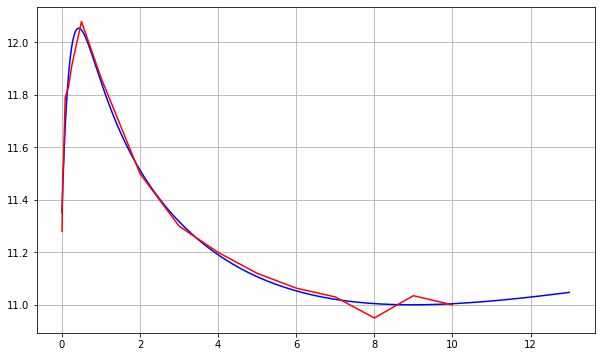

In [41]:
x = np.arange(0, 13, 0.01)
y_= curve(x)
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(x, y_, color = 'b')
plt.grid()
plt.plot(date_info.index.values, date_info.values, color='r')
plt.show()

In [42]:
special_dates = {'2015-05-22': (7, 5),
 '2015-05-25': (2, 3),
 '2015-07-08': (2, 3),
 '2015-07-29': (2, 5),
 '2015-08-12': (9, 1),
 '2015-08-13': (9, 1),
 '2015-08-17': (4, 9),
 '2015-08-27': (1, 9),
 '2015-09-14': (6, 2),
 '2015-09-15': (1, 9),
 '2015-09-17': (0.5, 1),
 '2015-09-18': (2, 5),
 '2015-09-21': (2,  5),
 '2015-09-22': (4, 7),
 '2015-09-23': (1, 8),
 '2015-09-24': (2, 7),
 '2015-09-25': (1, 8),
 '2015-09-28': (1, 8),
 '2015-09-29': (19, 8),
 '2015-09-30': (1, 7),
 '2015-10-01': (1, 7),
 '2015-10-02': (1, 7),
 '2015-10-05': (1, 7),
 '2015-10-06': (4, 2),
 '2015-10-07': (4 ,2),
 '2015-12-17': (3, 6),
 '2015-12-23': (3, 7),
 '2015-12-24': (3, 7),
 '2015-12-25': (3, 7),
 '2015-12-28': (3, 7),
 '2015-12-29': (3, 7),
 '2015-12-30': (3, 7),
 '2016-01-04': (3, 7),
 '2016-01-05': (3, 7),
 '2016-01-06': (3, 7),
 '2016-01-11': (3, 7),
 '2016-01-12': (3, 7),
 '2016-01-13': (3, 7),
 '2016-01-14': (3, 7),
 '2016-01-15': (3, 7),
 '2016-01-18': (3, 7),
 '2016-02-10': (3, 0.5),
 '2016-02-11': (4, 0.5),
 '2016-02-18': (2, 5),
 '2016-02-19': (2, 5)
 }

### Calibration and fitting

In [43]:
def make_curve(current_date, par = None):
    date_info = current_date.dropna()
    if par:
        curve, status = calibrate_nss_ols(date_info.index.values, 
                                 date_info.values,  tau0=par)
    else:
        try:
            curve, status = calibrate_nss_ols(date_info.index.values, 
                                     date_info.values,  tau0=(1, 0.5))
        except:
            curve, status = calibrate_nss_ols(date_info.index.values, 
                                     date_info.values,  tau0=(2, 0.5))
    if not status.success:
        counter = 1
    else:
        counter = 0
    return curve, counter

In [44]:
def return_time_until_red(curr_date, redemption_date): 
    date_red = pd.to_datetime(redemption_date, format = '%d.%m.%Y').date() #Such format is due to initial date format
    #in bonds file
    return (date_red - curr_date.date()).days / 365

In [45]:
import json
file = open(os.path.join(base_path, 'data/raw_data/bonds_info.json'), 'r')
data_bonds = json.load(file)

In [46]:
from datetime import datetime
import time

In [47]:
from tqdm import tqdm
def create_market_target(bond_file, rates_market):
    columns_for_df = list(bond_file.keys())
    index_for_df = rates_market.index
    target_df = pd.DataFrame(columns = columns_for_df,
                             index = index_for_df)
    not_fitted_correctly = 0
    counter_special = 0
    sum_of_squared_erros = []
    dates_sse = []
    for date in tqdm(index_for_df):
        rates_to_fit = rates_market.loc[date]
        if rates_to_fit.name.strftime('%Y-%m-%d') in special_dates.keys():
            counter_special +=1
            params_ = special_dates[rates_to_fit.name.strftime('%Y-%m-%d')]
            curve_fitted, counter = make_curve(rates_to_fit, params_)
        else:
            curve_fitted, counter = make_curve(rates_to_fit)
            not_fitted_correctly += counter
        yields_bonds = []
        ### Get SSE ####
        errors = curve_fitted(rates_to_fit.dropna().index.values) - rates_to_fit.dropna().values
        sse = np.sum(errors ** 2)
        sum_of_squared_erros.append(sse)
        dates_sse.append(rates_to_fit.name)
        ### ------  #### 
        for bond in columns_for_df:
            til_red = return_time_until_red(date, bond_file[bond]['redemption_date'])
            yields_bonds.append(curve_fitted(til_red))
        target_df.loc[date] = yields_bonds
    print(f'{not_fitted_correctly} fitted not completely')
    return target_df, sum_of_squared_erros, dates_sse

In [48]:
target_market, sse, dates_sse = create_market_target(data_bonds, rates)

 36%|███▌      | 85/239 [00:02<00:04, 35.50it/s]/opt/anaconda3/lib/python3.8/site-packages/nelson_siegel_svensson/nss.py:43: RuntimeWarning: overflow encountered in exp
  exp_tt2 = exp(-T/tau2)
/opt/anaconda3/lib/python3.8/site-packages/nelson_siegel_svensson/nss.py:46: RuntimeWarning: invalid value encountered in subtract
  factor3 = (1 - exp_tt2) / (T / tau2) - exp_tt2
 41%|████      | 97/239 [00:02<00:04, 34.89it/s]/opt/anaconda3/lib/python3.8/site-packages/nelson_siegel_svensson/nss.py:43: RuntimeWarning: overflow encountered in exp
  exp_tt2 = exp(-T/tau2)
/opt/anaconda3/lib/python3.8/site-packages/nelson_siegel_svensson/nss.py:46: RuntimeWarning: invalid value encountered in subtract
  factor3 = (1 - exp_tt2) / (T / tau2) - exp_tt2
 47%|████▋     | 112/239 [00:03<00:03, 40.66it/s]/opt/anaconda3/lib/python3.8/site-packages/nelson_siegel_svensson/nss.py:43: RuntimeWarning: overflow encountered in exp
  exp_tt2 = exp(-T/tau2)
/opt/anaconda3/lib/python3.8/site-packages/nelson_siegel_

77 fitted not completely


In [49]:
target_market.head(2)

,SU26214RMFS,SU26215RMFS,SU26216RMFS,SU26217RMFS,SU26218RMFS,SU26203RMFS,SU26204RMFS,SU26205RMFS,SU26206RMFS,SU26207RMFS,SU26208RMFS,SU26209RMFS,SU26210RMFS,SU26211RMFS,SU26212RMFS
Date,,,,,,,,,,,,,,,
2015-03-02,13.840569,13.436397,14.10409,13.638814,13.115709,16.225183,14.616077,13.687301,15.185467,13.245579,14.174794,13.531775,13.943358,13.48255,13.21098
2015-03-03,13.827112,13.432956,14.087667,13.629846,13.121495,16.25466,14.604137,13.677125,15.187871,13.24761,14.15823,13.525661,13.928297,13.477806,13.21401


In [50]:
target_market.isna().sum().sum()

0

In [51]:
target_market.shape

(239, 15)

In [52]:
target_market = target_market.astype('float')

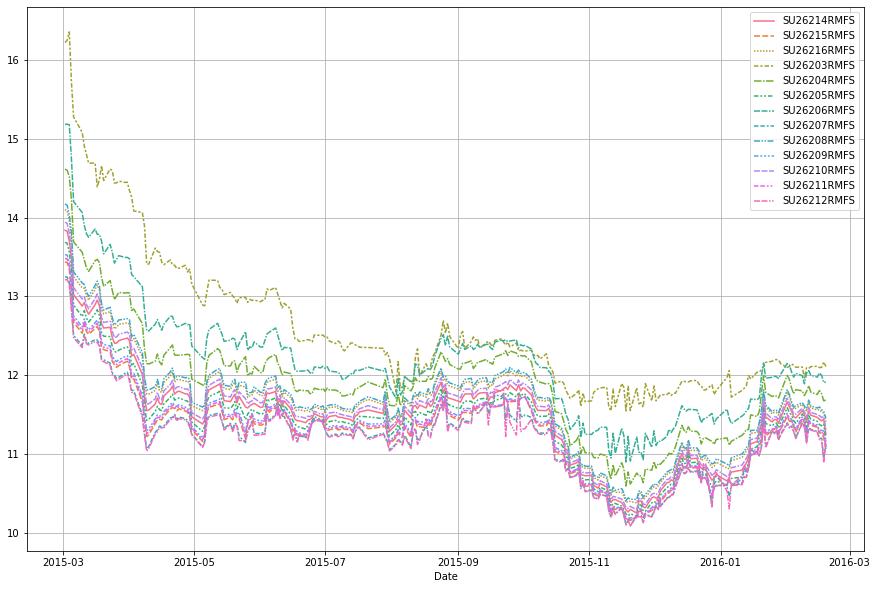

In [54]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data = target_market.drop(columns=['SU26217RMFS', 'SU26218RMFS']))
plt.grid()
plt.savefig(os.path.join(base_path, 'graphs/all_OTC_rates.png'), dpi=300)

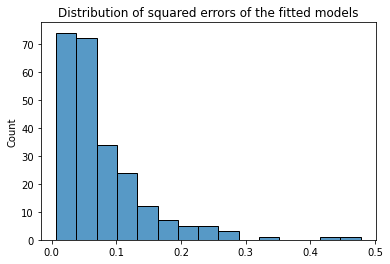

In [55]:
fig, ax = plt.subplots()
sns.histplot(sse, bins=15)
plt.title('Distribution of squared errors of the fitted models')
plt.show()

In [56]:
sse_info = pd.DataFrame(sse, columns = ['SSE'], index = dates_sse)
sse_info.index.name = 'Date'

# 90th Percentile
def q90(x):
    return x.quantile(0.9)

def q10(x):
    return x.quantile(0.1)

sse_info = sse_info.resample('M').agg({'SSE': [min, q10, 'mean', 'median', q90, max]}).loc['2015-06':]
sse_info

SSE                                                  
                 min       q10      mean    median       q90       max
Date                                                                  
2015-06-30  0.008718  0.013697  0.054630  0.051198  0.100016  0.113831
2015-07-31  0.011956  0.016935  0.040097  0.033736  0.069454  0.098635
2015-08-31  0.008935  0.014724  0.070759  0.052939  0.117367  0.259222
2015-09-30  0.033139  0.054472  0.137508  0.126186  0.240769  0.278741
2015-10-31  0.006782  0.008188  0.032027  0.019881  0.067671  0.108603
2015-11-30  0.007603  0.019907  0.073764  0.050271  0.182037  0.193113
2015-12-31  0.011587  0.018632  0.059470  0.058206  0.103956  0.125530
2016-01-31  0.007042  0.010524  0.054422  0.040165  0.103914  0.217782
2016-02-29  0.008409  0.030212  0.052856  0.047066  0.083978  0.091750

In [57]:
sse_info.to_excel(os.path.join(base_path, 'stats/sse_info.xlsx'))

In [58]:
target_market.to_excel(os.path.join(base_path, 'data/market_target.xlsx'))

## Same but for MosPrime rate

- restart the kernel before

In [11]:
mos = pd.read_excel(os.path.join(base_path, 'data/raw_data/rates_OTC_market/mosprime_all.xlsx'), index_col='Date',
                       parse_dates = True)
mos.head(3)

,overnight_mosprime,1W,2W,1M,2M,3M,6M
Date,,,,,,,
2015-03-02,15.95,15.99,16.06,16.56,16.76,17.07,17.07
2015-03-03,15.96,15.98,16.06,16.55,16.76,17.06,17.09
2015-03-04,15.94,15.98,16.05,16.50,16.73,17.05,17.08


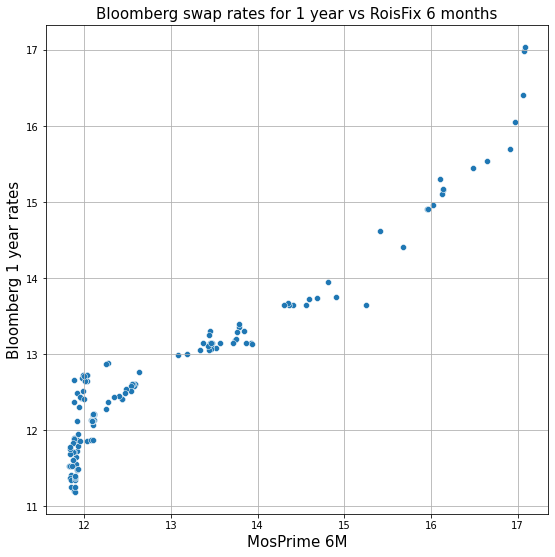

In [12]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.scatterplot(x = mos['6M'], y = rates['1_year'])
plt.xlabel('MosPrime 6M', fontsize=15)
plt.ylabel('Bloomberg 1 year rates', fontsize=15)
plt.title('Bloomberg swap rates for 1 year vs RoisFix 6 months', fontsize=15)
plt.grid()
plt.show()

In [13]:
data_for_reg = pd.DataFrame(mos['6M'].reset_index()).merge( #mos
               pd.DataFrame(rates['1_year'].reset_index()), 
               how='outer', on='Date')

data_for_reg['6M_2'] = data_for_reg['6M'] ** 2
data_for_reg['6M_3'] = data_for_reg['6M'] ** 3
data_for_reg['const'] = 1

data_for_reg.head(2)

,Date,6M,1_year,6M_2,6M_3,const
0,2015-03-02,17.07,16.99,291.3849,4973.940243,1
1,2015-03-03,17.09,17.04,292.0681,4991.443829,1


In [14]:
to_fill = data_for_reg.loc[data_for_reg['1_year'].isna() == True] #sample to be filled later
data_for_reg = data_for_reg.loc[data_for_reg.isna().sum(axis=1) == 0] #sample for regression

train = data_for_reg.sample(n = 125, random_state = 27) #85%
test = data_for_reg.loc[~data_for_reg.index.isin(train.index)]

In [15]:
from statsmodels.regression.linear_model import OLS

model = OLS(train['1_year'], train[['6M', '6M_2', '6M_3','const']]).fit()
predictions = model.predict()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 1_year   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     572.6
Date:                Sat, 16 Apr 2022   Prob (F-statistic):           2.72e-71
Time:                        16:20:22   Log-Likelihood:                -22.424
No. Observations:                 125   AIC:                             52.85
Df Residuals:                     121   BIC:                             64.16
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
6M            51.5248      6.906      7.460      0.000      37.852      65.198
6M_2          -3.6558      0.492     -7.424      0.000      -4.631      -2.681
6M_3           0.0871      0.012      7.496      0.000       0.064       0.110
const       -230.3286     32.054     -7.186      0.000    -293.788    -166.869
==============================================================================
Omnibus:                       15.034   Durbin-Watson:                   2.408
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.598
Skew:                           0.737   Prob(JB):                     0.000151
Kurtosis:                       4.099   Cond. No.                     2.94e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
test_predictions = model.predict(test[['6M', '6M_2', '6M_3','const']])
print(f'R squared: {r2_score(test["1_year"], test_predictions)}')
print(f'MSE: {mean_squared_error(test["1_year"], test_predictions)}')
print(f'RMSE: {mean_squared_error(test["1_year"], test_predictions, squared=False)}')

R squared: 0.8980207603111993
MSE: 0.17950543584399212
RMSE: 0.42368081835739524
